In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fmin_bfgs
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# custom percentile function to exactly replicate matlab
def quantile(x,q):
    n = len(x)
    y = np.sort(x)
    return(np.interp(q, np.linspace(1/(2*n), (2*n-1)/(2*n), n), y))

def prctile(x,p):
    return(quantile(x,np.array(p)/100))
# discussion: https://stackoverflow.com/questions/24764966/numpy-percentile-function-different-from-matlabs-percentile-function

In [2]:
# load GKX data 
data_stocks_dir = './'
micro = pd.read_pickle(data_stocks_dir + 'returns_chars_panel_raw.pkl') # use dropbox links to download this
macro = pd.read_pickle(data_stocks_dir + 'macro_timeseries.pkl')
df = pd.merge(micro,macro,on='date',how='left',suffixes=['','_macro']) # include macro predictors

In [3]:
micro = micro[['date', 'permno', 'ret', 'rfree']].sort_values(by='date')
micro = micro[(micro['date'] >= '1974-01-01') & (micro['date'] < '2016-01-01')]
rfree = micro[['date', 'rfree']]
rfree = rfree.groupby('date').mean()
df = micro.pivot(index='date', columns='permno', values='ret')
del micro, macro
df

permno,10000,10001,10002,10003,10005,10006,10007,10008,10009,10010,...,93427,93428,93429,93430,93431,93432,93433,93434,93435,93436
date,,,,,,,,,,,,,,,,,,,,,
1974-01-01,NaN,NaN,NaN,NaN,NaN,-0.010799,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-02-01,NaN,NaN,NaN,NaN,NaN,-0.041921,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-03-01,NaN,NaN,NaN,NaN,NaN,-0.041475,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-04-01,NaN,NaN,NaN,NaN,NaN,-0.115385,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN,NaN,-0.073913,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-01,NaN,-0.111665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.071121,-0.096220,0.020652,NaN,NaN,NaN,-0.163342,0.118568,NaN,-0.064212
2015-09-01,NaN,0.003367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.077968,-0.050697,0.064022,NaN,NaN,NaN,0.058122,-0.080000,NaN,-0.002650
2015-10-01,NaN,0.001678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.182215,0.067089,-0.000596,NaN,NaN,NaN,-0.154930,-0.002174,NaN,-0.166948


100%|██████████| 504/504 [00:11<00:00, 45.02it/s]


Text(0, 0.5, 'number of stocks')

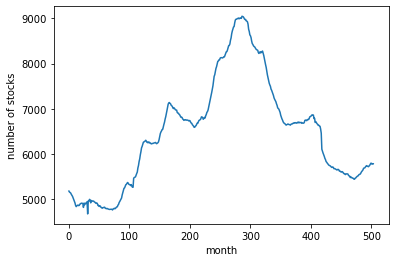

In [5]:
target_number_list = []
for i in tqdm(range(len(df))):
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    target_number_list.append(len(target_columns))

plt.plot(target_number_list)
plt.xlabel('month')
plt.ylabel('number of stocks')

In [4]:
index = 400
mini_df = df[index-120:index]
target_columns = df[index:index+1].dropna(axis=1).columns[0:1000]
mini_df = mini_df[target_columns]
mini_df

permno,10001,10002,10025,10026,10028,10032,10042,10044,10051,10065,...,53604,53612,53613,53640,53663,53727,53815,53831,53859,53866
date,,,,,,,,,,,,,,,,,,,,,
1997-05-01,0.000000,0.155963,0.015873,0.117647,0.300000,0.438095,0.268293,0.285714,0.324074,0.060000,...,0.076090,-0.053861,0.198582,0.029703,0.156566,0.173745,-0.142857,0.107639,-0.020294,-0.014354
1997-06-01,-0.030725,0.038095,-0.166667,0.078947,0.076923,0.478477,-0.230769,0.000000,-0.034965,0.062857,...,0.014085,0.102632,-0.053254,-0.019231,0.103755,0.076316,0.022222,0.020063,0.053435,0.067767
1997-07-01,0.045455,0.092308,-0.381250,0.024390,0.214286,-0.063830,-0.100000,0.055556,0.449275,0.048387,...,0.083333,0.028640,0.212500,0.083333,0.119433,0.012225,-0.076087,0.372308,-0.014493,0.189498
1997-08-01,0.014493,0.070423,0.090909,-0.015873,-0.088235,0.107656,0.000000,0.026316,-0.030000,-0.028410,...,-0.002436,-0.055128,-0.082474,0.212670,0.010850,-0.115942,0.076471,-0.024664,0.090000,-0.021113
1997-09-01,0.026857,0.097895,0.370370,0.048387,0.032258,0.213823,0.222222,0.320513,0.231959,0.050398,...,0.029126,0.054321,-0.220506,0.029851,0.063542,-0.016251,0.163934,0.074851,-0.006849,0.077294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-12-01,-0.037294,0.059480,0.035749,0.083725,0.032520,-0.011180,-0.056180,0.003481,0.075714,0.017608,...,0.230365,0.031395,-0.043836,-0.048426,-0.008099,0.033436,0.011404,0.016805,0.007531,0.055396
2007-01-01,0.023279,-0.158307,-0.125305,-0.002899,0.078701,-0.296482,-0.023810,-0.085034,0.188579,0.002884,...,0.092778,0.014630,-0.072350,-0.073791,-0.080114,-0.008462,-0.032090,-0.045850,-0.018687,0.104671
2007-02-01,0.261621,0.033054,-0.028094,-0.038517,-0.062375,-0.023810,-0.121951,0.021561,0.303911,-0.006477,...,-0.283663,0.071163,-0.084170,0.113187,-0.061324,0.006526,-0.085125,-0.136524,-0.004761,-0.106173


In [5]:
cov_matrix = mini_df.cov()
cov_matrix

permno,10001,10002,10025,10026,10028,10032,10042,10044,10051,10065,...,53604,53612,53613,53640,53663,53727,53815,53831,53859,53866
permno,,,,,,,,,,,,,,,,,,,,,
10001,0.009527,-0.000271,0.000922,-0.000628,0.001854,0.000638,0.000857,-0.000573,0.002329,0.000130,...,0.000770,0.000578,0.002433,0.000921,0.001175,0.001055,0.000305,0.000297,0.000893,-0.000531
10002,-0.000271,0.007730,0.000050,0.001086,-0.000752,0.000036,0.000609,0.002699,0.003289,-0.000052,...,0.000364,0.000944,0.001002,-0.000819,0.000879,0.000883,-0.000816,0.002518,0.000621,0.000691
10025,0.000922,0.000050,0.027311,0.004017,-0.002097,-0.000313,0.002425,0.003783,-0.003142,0.000982,...,0.000415,0.000397,-0.000010,0.001913,0.000665,0.002556,0.002703,-0.001761,0.000297,0.000174
10026,-0.000628,0.001086,0.004017,0.009285,-0.000677,0.002789,0.002366,0.002874,0.003469,0.001313,...,0.002414,0.001190,0.003381,-0.000103,0.000971,0.001742,0.001812,0.002894,0.000813,0.002534
10028,0.001854,-0.000752,-0.002097,-0.000677,0.039616,0.002547,0.008051,-0.001154,-0.000378,0.002098,...,0.003547,-0.001429,0.007201,0.006112,0.002687,0.001747,0.002676,0.004438,0.001161,-0.000558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53727,0.001055,0.000883,0.002556,0.001742,0.001747,0.006486,0.002768,-0.000300,0.002864,0.001996,...,0.001778,0.000368,0.005261,0.003886,-0.000022,0.006655,0.001807,0.001221,0.000912,0.000971
53815,0.000305,-0.000816,0.002703,0.001812,0.002676,0.004644,0.004035,0.003304,0.001826,0.001828,...,0.003086,0.000144,0.001486,0.006631,0.000804,0.001807,0.016333,0.004293,-0.000115,0.003434
53831,0.000297,0.002518,-0.001761,0.002894,0.004438,0.005081,0.000271,0.002334,0.003295,0.001791,...,0.001505,0.001651,0.003855,0.002887,0.002051,0.001221,0.004293,0.010691,0.000224,0.003805


In [8]:
training_size = 120
in_sample_size = 240
in_sample_ex_return = []
in_sample_return = []
for i in tqdm(range(training_size, training_size + in_sample_size)):
    mini_df = df[i-training_size:i]
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    random.shuffle(target_columns)
    target_columns = target_columns[0:1000]
    mini_df = mini_df[target_columns]
    cov_matrix = mini_df.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_portfolios = 50
    for portfolio in range(num_portfolios):
        weights = np.random.random(len(target_columns))
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, mini_df.apply(lambda x:np.product(1+x)) / (len(mini_df) / 12)) # Returns are the product of individual expected returns of asset and its weights
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(12) # Annual standard deviation = volatility
        p_vol.append(ann_sd)
    

    data = {'Returns':p_ret, 'Volatility':p_vol}

    portfolios  = pd.DataFrame(data)
    rf = float(rfree[i:i+1].values) * 12 # risk factor
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-float(np.product(1 + rfree[i-training_size:i].values) / (training_size / 12)))/portfolios['Volatility']).idxmax()]
    portfolio_ex_return = optimal_risky_port[0] - rf
    portfolio_return = optimal_risky_port[0]

    in_sample_ex_return.append(portfolio_ex_return)
    in_sample_return.append(portfolio_return)
sharpe_ratio = np.array(in_sample_ex_return).mean() / np.array(in_sample_return).std()
print()
print('In Sample Data Sharpe Ratio', sharpe_ratio)

100%|██████████| 240/240 [15:35<00:00,  3.90s/it]
In Sample Data Sharpe Ratio 2.6198706795510396



In [9]:
training_size = 120
out_of_sample_size = 144
out_sample_ex_return = []
out_sample_return = []
for i in tqdm(range(in_sample_size, in_sample_size + out_of_sample_size)):
    mini_df = df[i-training_size:i]
    target_columns = list(df[i:i+1].dropna(axis=1).columns)
    random.shuffle(target_columns)
    target_columns = target_columns[0:1000]
    mini_df = mini_df[target_columns]
    cov_matrix = mini_df.cov()

    p_ret = [] # Define an empty array for portfolio returns
    p_vol = [] # Define an empty array for portfolio volatility
    p_weights = [] # Define an empty array for asset weights

    num_portfolios = 50
    for portfolio in range(num_portfolios):
        weights = np.random.random(len(target_columns))
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, mini_df.apply(lambda x:np.product(1+x)) / (len(mini_df) / 12)) # Returns are the product of individual expected returns of asset and its weights
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(var) # Daily standard deviation
        ann_sd = sd*np.sqrt(12) # Annual standard deviation = volatility
        p_vol.append(ann_sd)
    

    data = {'Returns':p_ret, 'Volatility':p_vol}

    portfolios  = pd.DataFrame(data)
    rf = float(rfree[i:i+1].values) * 12 # risk factor
    optimal_risky_port = portfolios.iloc[((portfolios['Returns']-float(np.product(1 + rfree[i-training_size:i].values) / (training_size / 12)))/portfolios['Volatility']).idxmax()]
    portfolio_ex_return = optimal_risky_port[0] - rf
    portfolio_return = optimal_risky_port[0]

    out_sample_ex_return.append(portfolio_ex_return)
    out_sample_return.append(portfolio_return)
sharpe_ratio = np.array(out_sample_ex_return).mean() / np.array(in_sample_return).std()
print()
print('Out of sample Data Sharpe Ratio', sharpe_ratio)

100%|██████████| 144/144 [09:23<00:00,  3.91s/it]
Out of sample Data Sharpe Ratio 2.3262337869644307

